In [6]:
import tensorflow as tf
from tensorflow import keras

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
print(tf.version.VERSION)

2.3.0


In [5]:
import sys
sys.version

'3.7.13 (default, Mar 28 2022, 08:03:21) [MSC v.1916 64 bit (AMD64)]'

In [6]:
print(keras.__version__)

2.4.0


In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [8]:
IMAGE_SIZE=[512, 512]
EPOCHS = 20
# BATCH_SIZE = 8 * strategy.num_replicas_in_sync
BATCH_SIZE = 64

In [9]:
pth = 'E:/_DOWNLOADED/'
img_pth = 'E:/_DOWNLOADED/archive/'

train_df_main  = pd.read_csv(os.path.join(pth, 'train_df.csv'))


train_df_main .drop(['No Finding'], axis = 1, inplace = True)
labels = train_df_main .columns[2:-1]
labels

Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],
      dtype='object')

In [10]:
train_df_main['FilePath'] = train_df_main['FilePath'].str.replace('../input/data','E:/_DOWNLOADED/archive')
train_df_main['FilePath'].sample(10)

97457     E:/_DOWNLOADED/archive/images_011/images/00025...
91747     E:/_DOWNLOADED/archive/images_010/images/00022...
72481     E:/_DOWNLOADED/archive/images_008/images/00017...
70060     E:/_DOWNLOADED/archive/images_008/images/00017...
57932     E:/_DOWNLOADED/archive/images_007/images/00014...
104621    E:/_DOWNLOADED/archive/images_011/images/00028...
12515     E:/_DOWNLOADED/archive/images_002/images/00003...
81389     E:/_DOWNLOADED/archive/images_009/images/00019...
88026     E:/_DOWNLOADED/archive/images_010/images/00021...
51659     E:/_DOWNLOADED/archive/images_006/images/00013...
Name: FilePath, dtype: object

In [11]:
from sklearn.model_selection import train_test_split
train_df, discard = train_test_split(train_df_main, test_size = 0.7, random_state = 1993)

train_and_valid_set, test_set = train_test_split(train_df, test_size = 0.2, random_state = 1993)
train_set, valid_set = train_test_split(train_and_valid_set, test_size = 0.2, random_state = 1993)

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

from keras.models import load_model
import tensorflow.keras.layers as L

Using TensorFlow backend.


In [13]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
      
    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True, 
        shear_range=0.1,
        zoom_range=0.15,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.05,
        horizontal_flip=True, 
        vertical_flip = False, 
        fill_mode = 'reflect')
    
    
    # flow from directory with specified batch size
    # and target image size
    
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [14]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):

    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="FilePath", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [15]:
train_generator = get_train_generator(df = train_set,
                                      image_dir = None, 
                                      x_col = "FilePath",
                                      y_cols = labels, 
                                      batch_size=BATCH_SIZE,
                                      target_w = IMAGE_SIZE[0], 
                                      target_h = IMAGE_SIZE[1] 
                                      )

valid_generator, test_generator= get_test_and_valid_generator(valid_df = valid_set, 
                                                              test_df = test_set, 
                                                              train_df = train_set,
                                                              image_dir = None, 
                                                              x_col = "FilePath", 
                                                              y_cols = labels,
                                                              batch_size = BATCH_SIZE,
                                                              target_w = IMAGE_SIZE[0], 
                                                              target_h = IMAGE_SIZE[1])


getting train generator...
Found 21526 validated image filenames.
getting train and valid generators...
Found 21526 validated image filenames.
Found 5382 validated image filenames.
Found 6728 validated image filenames.


In [1]:
keras.backend.clear_session()

NameError: name 'keras' is not defined

In [48]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [49]:
eff = EfficientNetB1(include_top = False, input_shape=(150,150,3))
for layer in eff.layers:
    layer.trainable = False

In [50]:


model = models.Sequential()
model.add(eff)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(14, activation='softmax'))


In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 5, 5, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                7

In [52]:
optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss ='binary_crossentropy',
              metrics = [tf.keras.metrics.AUC(name="auc")])

In [53]:
plateau = callbacks.ReduceLROnPlateau(monitor='val_auc',
                                     patience = 1,
                                     factor = 0.01,
                                     mode = 'max')

early_tight_layouting = callbacks.EarlyStopping(monitor = 'val_auc',
                                        patience = 4,
                                        restore_best_weights=True,
                                        mode = 'max')

In [54]:
history = model.fit(train_generator, epochs = 5,verbose=2,
          callbacks=[plateau, early_stopping], validation_data=valid_generator)

Epoch 1/5
337/337 - 1297s - loss: 0.1904 - auc: 0.7340 - val_loss: 0.1905 - val_auc: 0.7447
Epoch 2/5
337/337 - 1292s - loss: 0.1893 - auc: 0.7396 - val_loss: 0.1901 - val_auc: 0.7466
Epoch 3/5
337/337 - 1282s - loss: 0.1892 - auc: 0.7393 - val_loss: 0.1906 - val_auc: 0.7433
Epoch 4/5
337/337 - 1280s - loss: 0.1891 - auc: 0.7393 - val_loss: 0.1902 - val_auc: 0.7447
Epoch 5/5
337/337 - 1304s - loss: 0.1890 - auc: 0.7392 - val_loss: 0.1902 - val_auc: 0.7447


#### Evaluate the model

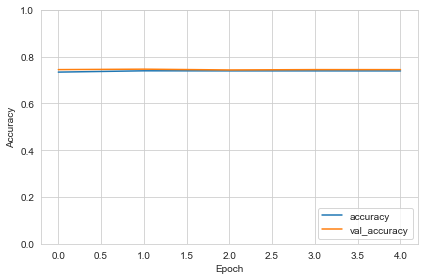

In [56]:

plt.plot(history.history['auc'], label='accuracy')
plt.plot(history.history['val_auc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
plt.tight_layout()


In [57]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

106/106 - 141s - loss: 0.1862 - auc: 0.7419


In [58]:
print(test_acc)

0.7418763637542725
